In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy.stats import chi2_contingency


In [2]:
# Read the relevant data files
data_path = '/Users/crishnagarkar/Documents/R STATS/simulacrum_release_v1.2.0.2017/data/'



In [3]:
# 1. Data Preprocessing
patient_df = pd.read_csv(data_path + 'sim_sact_patient.csv')
regimen_df = pd.read_csv(data_path + 'sim_sact_regimen.csv')
outcome_df = pd.read_csv(data_path + 'sim_sact_outcome.csv')
tumour_df = pd.read_csv(data_path + 'sim_sact_tumour.csv')
av_patient_df = pd.read_csv(data_path + 'sim_av_patient.csv')



In [12]:
print("Columns in merged_df:")
print(merged_df.columns)
print("\nColumns in tumour_df:")
print(tumour_df.columns)


Columns in merged_df:
Index(['MERGED_PATIENT_ID_x', 'LINK_NUMBER', 'MERGED_REGIMEN_ID',
       'MERGED_TUMOUR_ID_x', 'HEIGHT_AT_START_OF_REGIMEN',
       'WEIGHT_AT_START_OF_REGIMEN', 'INTENT_OF_TREATMENT',
       'DATE_DECISION_TO_TREAT', 'START_DATE_OF_REGIMEN', 'MAPPED_REGIMEN',
       'CLINICAL_TRIAL', 'CHEMO_RADIATION', 'BENCHMARK_GROUP',
       'MERGED_OUTCOME_ID', 'DATE_OF_FINAL_TREATMENT',
       'REGIMEN_MOD_DOSE_REDUCTION', 'REGIMEN_MOD_TIME_DELAY',
       'REGIMEN_MOD_STOPPED_EARLY', 'REGIMEN_OUTCOME_SUMMARY',
       'MERGED_PATIENT_ID_y', 'MERGED_TUMOUR_ID_y'],
      dtype='object')

Columns in tumour_df:
Index(['MERGED_TUMOUR_ID', 'MERGED_PATIENT_ID', 'CONSULTANT_SPECIALITY_CODE',
       'PRIMARY_DIAGNOSIS', 'MORPHOLOGY_CLEAN'],
      dtype='object')


In [13]:
# Merge datasets
merged_df = pd.merge(patient_df, regimen_df, on='MERGED_PATIENT_ID')
merged_df = pd.merge(merged_df, outcome_df, on='MERGED_REGIMEN_ID')
merged_df = pd.merge(merged_df, tumour_df, left_on=['MERGED_PATIENT_ID_x', 'MERGED_TUMOUR_ID_x'], right_on=['MERGED_PATIENT_ID', 'MERGED_TUMOUR_ID'], how='left')
merged_df = pd.merge(merged_df, av_patient_df, left_on='MERGED_PATIENT_ID_x', right_on='PATIENTID')


In [14]:
# Handle missing values and data cleaning
merged_df = merged_df.dropna(subset=['MERGED_PATIENT_ID_x', 'MERGED_REGIMEN_ID', 'REGIMEN_OUTCOME_SUMMARY', 'VITALSTATUSDATE'])



In [15]:
# Convert dates to datetime format
merged_df['START_DATE_OF_REGIMEN'] = pd.to_datetime(merged_df['START_DATE_OF_REGIMEN'])
merged_df['VITALSTATUSDATE'] = pd.to_datetime(merged_df['VITALSTATUSDATE'])



In [16]:
# 2. Treatment Sequencing Analysis
sequence_df = merged_df.groupby(['MERGED_PATIENT_ID_x', 'MAPPED_REGIMEN']).size().reset_index(name='sequence_number')
sequence_df['sequence_number'] = sequence_df.groupby('MERGED_PATIENT_ID_x')['sequence_number'].cumsum()



In [17]:
# Analyze treatment sequence frequencies
sequence_freq = sequence_df.groupby('MAPPED_REGIMEN')['sequence_number'].value_counts().unstack()



In [18]:
# 3. Treatment Response Analysis
response_criteria = {
    'Complete Response': ['Complete Response', 'CR'],
    'Partial Response': ['Partial Response', 'PR'],
    'Stable Disease': ['Stable Disease', 'SD'],
    'Progressive Disease': ['Progressive Disease', 'PD']
}

def categorize_response(regimen_outcome):
    for category, criteria in response_criteria.items():
        if regimen_outcome in criteria:
            return category
    return 'Unknown'

merged_df['RESPONSE_CATEGORY'] = merged_df['REGIMEN_OUTCOME_SUMMARY'].apply(categorize_response)



In [19]:
# Analyze association between treatment sequences and response rates
response_table = pd.crosstab(merged_df['MAPPED_REGIMEN'], merged_df['RESPONSE_CATEGORY'])
chi2, p, _, _ = chi2_contingency(response_table)
print(f"Chi-square test p-value: {p:.4f}")


Chi-square test p-value: 1.0000


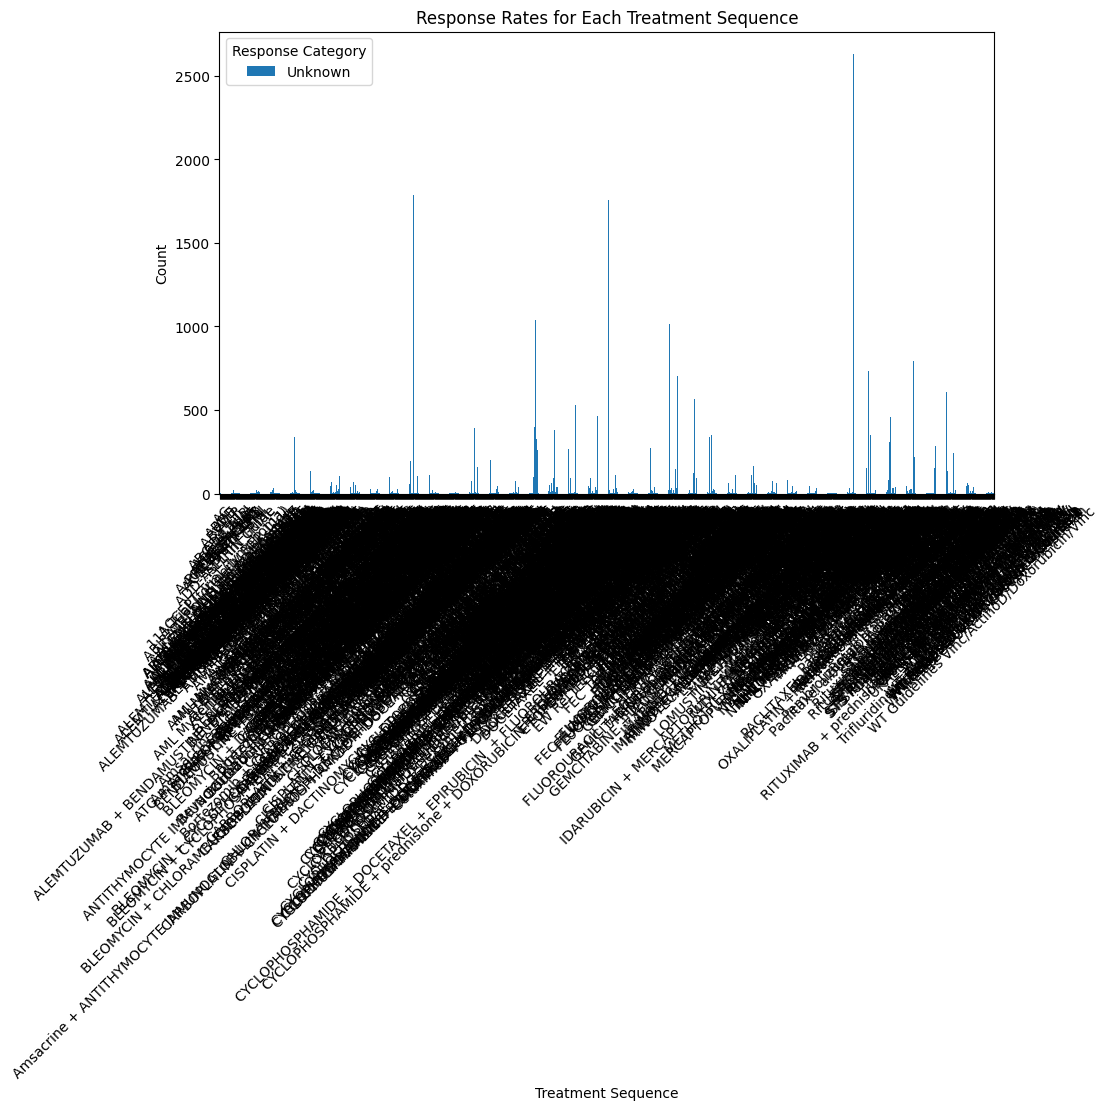

In [20]:
# Visualize response rates for each treatment sequence
response_table.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Response Rates for Each Treatment Sequence')
plt.xlabel('Treatment Sequence')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Response Category')
plt.show()


In [34]:
# 4. Survival Analysis
def calculate_survival_time(row):
    start_date = row['START_DATE_OF_REGIMEN']
    end_date = row['VITALSTATUSDATE']
    event = row['NEWVITALSTATUS'] == 'D'
    survival_time = (end_date - start_date).days
    return survival_time, event

merged_df[['SURVIVAL_TIME', 'EVENT']] = merged_df.apply(calculate_survival_time, axis=1, result_type='expand')



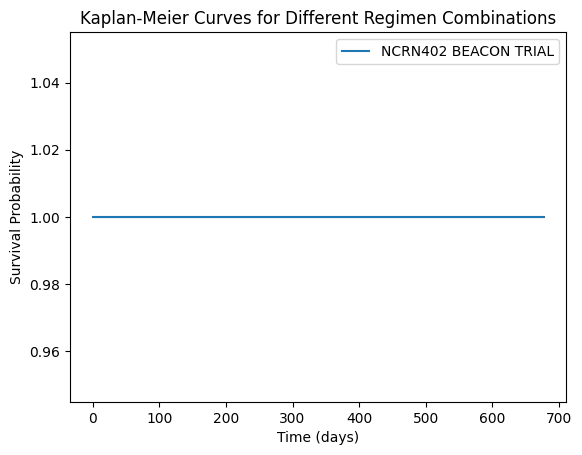

In [35]:
# Filter out rows where SURVIVAL_TIME is greater than 0
merged_df = merged_df[merged_df['SURVIVAL_TIME'] > 0]

# Perform Kaplan-Meier analysis
kmf = KaplanMeierFitter()
regimen_groups = merged_df['MAPPED_REGIMEN'].unique()

for regimen in regimen_groups:
    regimen_data = merged_df[merged_df['MAPPED_REGIMEN'] == regimen]
    
    # Check if there are any valid data points for the current regimen
    if len(regimen_data) > 0:
        kmf.fit(regimen_data['SURVIVAL_TIME'], event_observed=regimen_data['EVENT'], label=regimen)

# Plot Kaplan-Meier curves
if kmf.event_table.shape[0] > 0:
    kmf.plot(title='Kaplan-Meier Curves for Different Regimen Combinations')
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.show()
else:
    print("No valid data to plot Kaplan-Meier curves.")

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

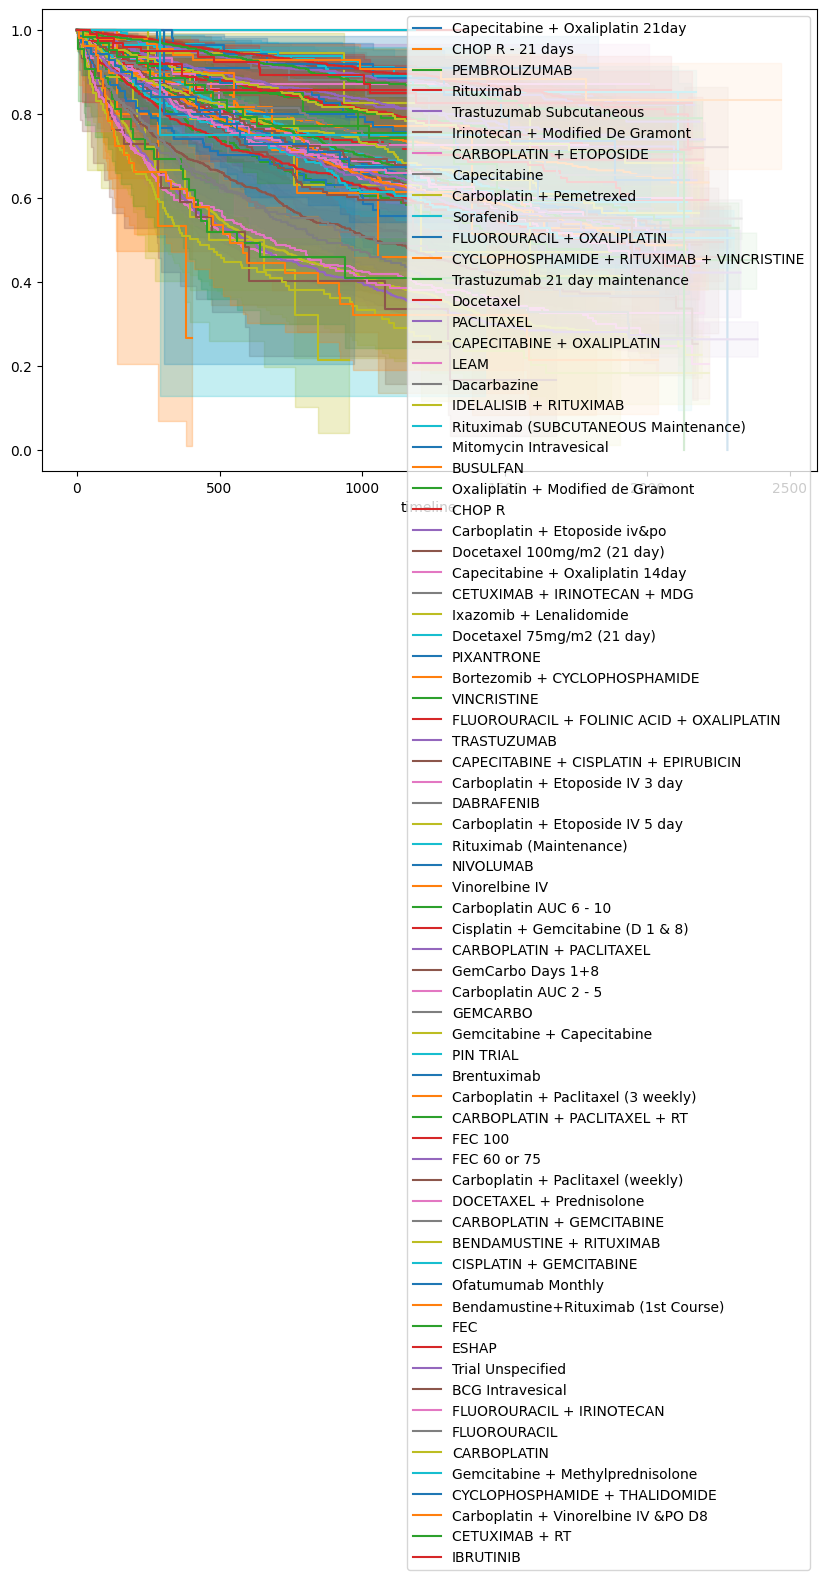

In [36]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Filter out rows where SURVIVAL_TIME is greater than 0
merged_df = merged_df[merged_df['SURVIVAL_TIME'] > 0]

# Perform Kaplan-Meier analysis
kmf = KaplanMeierFitter()
regimen_groups = merged_df['MAPPED_REGIMEN'].unique()

plt.figure(figsize=(10, 6))

for regimen in regimen_groups:
    regimen_data = merged_df[merged_df['MAPPED_REGIMEN'] == regimen]
    
    # Fit the Kaplan-Meier estimator
    kmf.fit(regimen_data['SURVIVAL_TIME'], event_observed=regimen_data['EVENT'], label=regimen)
    
    # Plot the Kaplan-Meier curve for each regimen
    kmf.plot()

# Plot settings
plt.title('Kaplan-Meier Curves for Different Regimen Combinations')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.show()


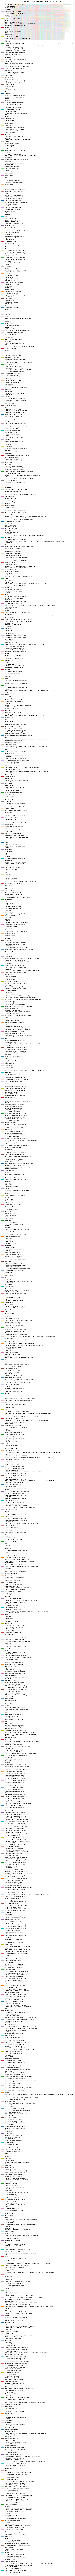

In [37]:
# Filter out rows where SURVIVAL_TIME is greater than 0
merged_df = merged_df[merged_df['SURVIVAL_TIME'] > 0]

# Get unique regimens
regimen_groups = merged_df['MAPPED_REGIMEN'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Perform Kaplan-Meier analysis for each regimen
for regimen in regimen_groups:
    regimen_data = merged_df[merged_df['MAPPED_REGIMEN'] == regimen]
    
    # Check if there are any valid data points for the current regimen
    if len(regimen_data) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(regimen_data['SURVIVAL_TIME'], event_observed=regimen_data['EVENT'], label=regimen)
        kmf.plot(ax=ax)

# Set plot title and labels
ax.set_title('Kaplan-Meier Curves for Different Regimen Combinations')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival Probability')

# Show the plot
plt.show()

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

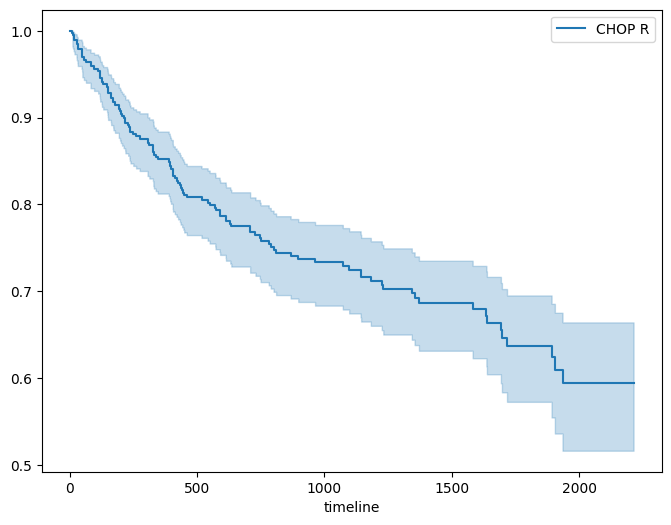

In [39]:
# Select a subset of key regimens
key_regimens = ['CHOP R', 'Capecitabine + Oxaliplatin', 'Carboplatin + Pemetrexed', 'CAPOX', 'FOLFOX']

# Filter the data for the key regimens
filtered_df = merged_df[merged_df['MAPPED_REGIMEN'].isin(key_regimens)]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Perform Kaplan-Meier analysis for each key regimen
for regimen in key_regimens:
    regimen_data = filtered_df[filtered_df['MAPPED_REGIMEN'] == regimen]
    kmf = KaplanMeierFitter()
    kmf.fit(regimen_data['SURVIVAL_TIME'], event_observed=regimen_data['EVENT'], label=regimen)
    kmf.plot(ax=ax)

# Customize the plot
ax.set_title('Kaplan-Meier Curves for Key Treatment Regimens')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival Probability')
ax.grid(True)
ax.legend(title='Regimen')

plt.tight_layout()
plt.show()

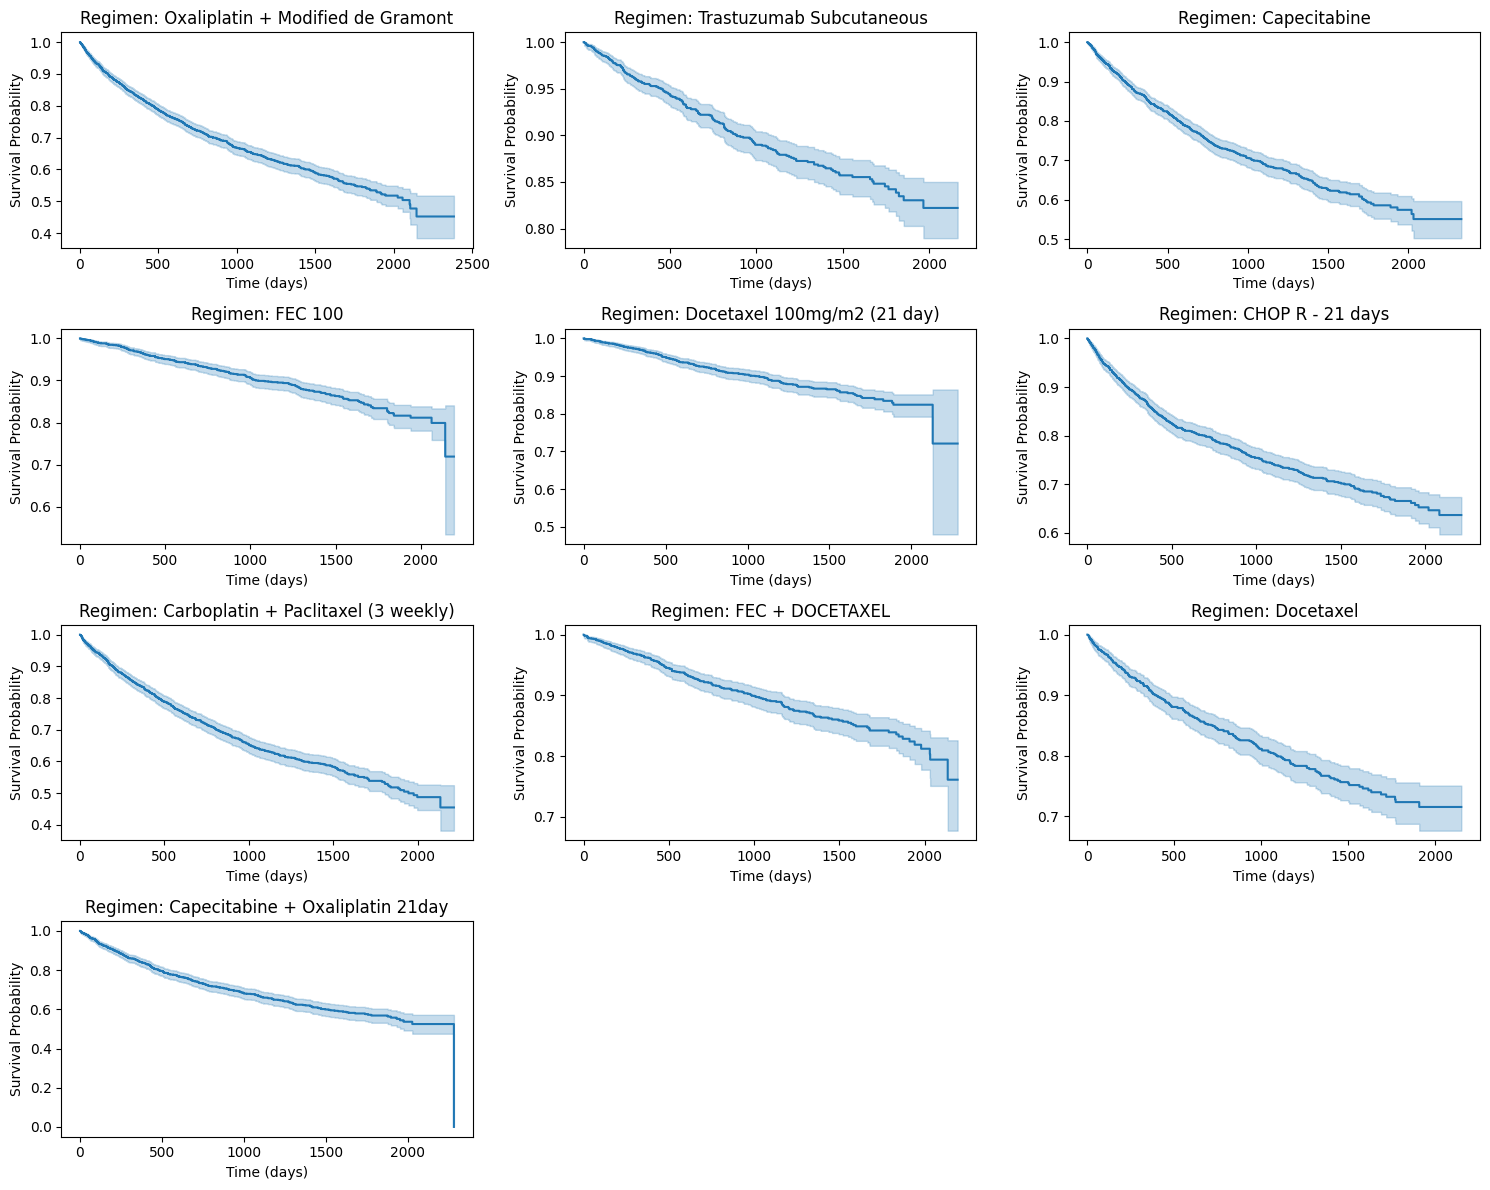

In [41]:
import math

# Set the number of top regimens to plot
N = 10  # You can adjust this value based on the number of regimens you want to include

# Filter out rows where SURVIVAL_TIME is greater than 0
merged_df = merged_df[merged_df['SURVIVAL_TIME'] > 0]

# Get top N most frequent regimens
top_n_regimens = merged_df['MAPPED_REGIMEN'].value_counts().nlargest(N).index

# Calculate the number of subplots required based on N
num_subplots = math.ceil(N / 3)

# Create a figure and subplots
fig, axes = plt.subplots(nrows=num_subplots, ncols=3, figsize=(15, num_subplots*3))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Perform Kaplan-Meier analysis for each regimen in the top N
for i, regimen in enumerate(top_n_regimens):
    ax = axes[i]
    regimen_data = merged_df[merged_df['MAPPED_REGIMEN'] == regimen]
    kmf.fit(regimen_data['SURVIVAL_TIME'], event_observed=regimen_data['EVENT'], label=regimen)
    kmf.plot(ax=ax)
    ax.set_title(f'Regimen: {regimen}')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Survival Probability')
    ax.legend_.remove()  # Remove legend for better readability

# Hide empty subplots
for j in range(N, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [54]:
print("Shape before removing missing values:", merged_df.shape)
print("Missing values count:")
print(merged_df[['SURVIVAL_TIME', 'EVENT', 'MAPPED_REGIMEN']].isnull().sum())

# Remove rows with missing values in the relevant columns
merged_df = merged_df.dropna(subset=['SURVIVAL_TIME', 'EVENT', 'MAPPED_REGIMEN'])

print("Shape after removing missing values:", merged_df.shape)

Shape before removing missing values: (77323, 41)
Missing values count:
SURVIVAL_TIME       0
EVENT               0
MAPPED_REGIMEN    254
dtype: int64
Shape after removing missing values: (77069, 41)


In [55]:
# Remove rows with missing values in the relevant columns
merged_df = merged_df.dropna(subset=['SURVIVAL_TIME', 'EVENT', 'MAPPED_REGIMEN'])

# Perform Cox proportional hazards regression
cph = CoxPHFitter()
cph.fit(merged_df, duration_col='SURVIVAL_TIME', event_col='EVENT', formula='MAPPED_REGIMEN - 1')

cph.plot(title='Hazard Ratios for Different Regimen Combinations')
plt.show()

/Users/crishnagarkar/anaconda3/lib/python3.11/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['MAPPED_REGIMEN[T.111 Trial (formerly BEP 111)]', 'MAPPED_REGIMEN[T.A-PREDICT TRIAL]', 'MAPPED_REGIMEN[T.ABC-08 Trial]', 'MAPPED_REGIMEN[T.ABIRATERONE + Enzalutamide]', 'MAPPED_REGIMEN[T.ABVD R]', 'MAPPED_REGIMEN[T.ACCEPT Trial (lymphoma)]', 'MAPPED_REGIMEN[T.ACE (3 day)]', 'MAPPED_REGIMEN[T.ACE (germ cell)]', 'MAPPED_REGIMEN[T.ACELARATE Trial]', 'MAPPED_REGIMEN[T.ADE]', 'MAPPED_REGIMEN[T.ADE 10+3+5]', 'MAPPED_REGIMEN[T.ADE 8+3+5]', 'MAPPED_REGIMEN[T.AFLIBERCEPT]', 'MAPPED_REGIMEN[T.ALCL ALCL 99 Closed AM 1, 2 or 3]', 'MAPPED_REGIMEN[T.ALCL ALCL 99 Closed BM 1, 2 or 3]', 'MAPPED_REGIMEN[T.ALCL ALCL 99 Closed Pre Phase]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB (Intravenous)]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB + BENDAMUSTINE + CYTARABINE + ETOPOSIDE + MELPHALAN]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB + BUSULFAN + CYCLOPHOSPHAMIDE]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB + ETOPOSIDE]', 'MAPPE

ConvergenceError: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model

In [53]:
# Perform Cox proportional hazards regression
cph = CoxPHFitter()
cph.fit(merged_df, duration_col='SURVIVAL_TIME', event_col='EVENT', formula='MAPPED_REGIMEN - 1')
cph.plot(title='Hazard Ratios for Different Regimen Combinations')
plt.show()


/Users/crishnagarkar/anaconda3/lib/python3.11/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['MAPPED_REGIMEN[T.111 Trial (formerly BEP 111)]', 'MAPPED_REGIMEN[T.A-PREDICT TRIAL]', 'MAPPED_REGIMEN[T.ABC-08 Trial]', 'MAPPED_REGIMEN[T.ABIRATERONE + Enzalutamide]', 'MAPPED_REGIMEN[T.ABVD R]', 'MAPPED_REGIMEN[T.ACCEPT Trial (lymphoma)]', 'MAPPED_REGIMEN[T.ACE (3 day)]', 'MAPPED_REGIMEN[T.ACE (germ cell)]', 'MAPPED_REGIMEN[T.ACELARATE Trial]', 'MAPPED_REGIMEN[T.ADE]', 'MAPPED_REGIMEN[T.ADE 10+3+5]', 'MAPPED_REGIMEN[T.ADE 8+3+5]', 'MAPPED_REGIMEN[T.AFLIBERCEPT]', 'MAPPED_REGIMEN[T.ALCL ALCL 99 Closed AM 1, 2 or 3]', 'MAPPED_REGIMEN[T.ALCL ALCL 99 Closed BM 1, 2 or 3]', 'MAPPED_REGIMEN[T.ALCL ALCL 99 Closed Pre Phase]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB (Intravenous)]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB + BENDAMUSTINE + CYTARABINE + ETOPOSIDE + MELPHALAN]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB + BUSULFAN + CYCLOPHOSPHAMIDE]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB + ETOPOSIDE]', 'MAPPE

ValueError: operands could not be broadcast together with shapes (77323,) (77069,) 

In [43]:
# Get unique regimen groups
regimen_groups = merged_df['MAPPED_REGIMEN'].unique()

# Perform log-rank test for each pair of groups
for i, group1 in enumerate(regimen_groups):
    for group2 in regimen_groups[i+1:]:
        log_rank_test_results = logrank_test(
            merged_df.loc[merged_df['MAPPED_REGIMEN'] == group1, 'SURVIVAL_TIME'],
            merged_df.loc[merged_df['MAPPED_REGIMEN'] == group2, 'SURVIVAL_TIME'],
            merged_df.loc[merged_df['MAPPED_REGIMEN'] == group1, 'EVENT'],
            merged_df.loc[merged_df['MAPPED_REGIMEN'] == group2, 'EVENT']
        )
        print(f"Log-rank test p-value for {group1} vs {group2}: {log_rank_test_results.p_value:.4f}")


Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs CHOP R - 21 days: 0.0000
Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs PEMBROLIZUMAB: 0.0016
Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs Rituximab: 0.0000
Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs Trastuzumab Subcutaneous: 0.0000
Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs Irinotecan + Modified De Gramont: 0.6814
Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs CARBOPLATIN + ETOPOSIDE: 0.0000
Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs Capecitabine: 0.1270
Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs Carboplatin + Pemetrexed: 0.0000
Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs Sorafenib: 0.9823
Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs FLUOROURACIL + OXALIPLATIN: 0.5436
Log-rank test p-value for Capecitabine + Oxaliplatin 21day vs CYCLOPHOSPHAMIDE + RITUXIMAB + VINCRISTI

KeyboardInterrupt: 

In [ ]:
from statsmodels.stats.multitest import multipletests

# Get unique regimen groups
regimen_groups = merged_df['MAPPED_REGIMEN'].unique()

# Perform log-rank test for each pair of groups
p_values = []
significant_pairs = []

for i, group1 in enumerate(regimen_groups):
    for group2 in regimen_groups[i+1:]:
        log_rank_test_results = logrank_test(
            merged_df.loc[merged_df['MAPPED_REGIMEN'] == group1, 'SURVIVAL_TIME'],
            merged_df.loc[merged_df['MAPPED_REGIMEN'] == group2, 'SURVIVAL_TIME'],
            merged_df.loc[merged_df['MAPPED_REGIMEN'] == group1, 'EVENT'],
            merged_df.loc[merged_df['MAPPED_REGIMEN'] == group2, 'EVENT']
        )
        p_values.append(log_rank_test_results.p_value)
        significant_pairs.append((group1, group2))

# Apply Bonferroni correction
reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')

# Print significant results
for p_value, pair, is_significant in zip(corrected_p_values, significant_pairs, reject):
    if is_significant:
        print(f"Significant difference between {pair[0]} and {pair[1]}: p-value = {p_value:.4f}")


In [52]:
# Perform Cox proportional hazards regression
cph = CoxPHFitter()
cph.fit(merged_df, duration_col='SURVIVAL_TIME', event_col='EVENT', formula='MAPPED_REGIMEN - 1')
cph.plot(title='Hazard Ratios for Different Regimen Combinations')
plt.show()


/Users/crishnagarkar/anaconda3/lib/python3.11/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['MAPPED_REGIMEN[T.111 Trial (formerly BEP 111)]', 'MAPPED_REGIMEN[T.A-PREDICT TRIAL]', 'MAPPED_REGIMEN[T.ABC-08 Trial]', 'MAPPED_REGIMEN[T.ABIRATERONE + Enzalutamide]', 'MAPPED_REGIMEN[T.ABVD R]', 'MAPPED_REGIMEN[T.ACCEPT Trial (lymphoma)]', 'MAPPED_REGIMEN[T.ACE (3 day)]', 'MAPPED_REGIMEN[T.ACE (germ cell)]', 'MAPPED_REGIMEN[T.ACELARATE Trial]', 'MAPPED_REGIMEN[T.ADE]', 'MAPPED_REGIMEN[T.ADE 10+3+5]', 'MAPPED_REGIMEN[T.ADE 8+3+5]', 'MAPPED_REGIMEN[T.AFLIBERCEPT]', 'MAPPED_REGIMEN[T.ALCL ALCL 99 Closed AM 1, 2 or 3]', 'MAPPED_REGIMEN[T.ALCL ALCL 99 Closed BM 1, 2 or 3]', 'MAPPED_REGIMEN[T.ALCL ALCL 99 Closed Pre Phase]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB (Intravenous)]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB + BENDAMUSTINE + CYTARABINE + ETOPOSIDE + MELPHALAN]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB + BUSULFAN + CYCLOPHOSPHAMIDE]', 'MAPPED_REGIMEN[T.ALEMTUZUMAB + ETOPOSIDE]', 'MAPPE

ValueError: operands could not be broadcast together with shapes (77323,) (77069,) 

In [47]:
merged_df.shape


(77323, 41)

In [48]:
len(weights)


NameError: name 'weights' is not defined